# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

<ipython-input-3-4ab6e7a8ed1f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
<ipython-input-3-4ab6e7a8ed1f>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [329]:
delta_11=1e-5
aaa = np.array([3.0])
aa = np.array([3.0, 2.0])
# bb = np.array([2.0, 1.0])
cc = np.array([[3.0, 2.0], [1.0, 0.0]])
# float(aaa * aaa)
# ((aaa[(0,)] + delta_11)*(aaa[(0,)] + delta_11) - (aaa[(0,)] - delta_11)*(aaa[(0,)] - delta_11)) / (2*delta_11)
# (aaa - delta_11)*(aaa - delta_11)
# float(2*aaa)
# (np.sum(aa) - np.sum(bb)) #/ 2.0

# (np.sum(cc + delta_11) - np.sum(cc))/ (delta_11)
# ((aa[0] + delta_11) - (aa[0] - delta_11)) / (2*delta_11)
# np.sum(((cc + delta_11) - (cc - delta_11)) / (2*delta_11))
# (cc[:, 1])
# aa + np.array([delta_11])
# (np.sum(cc + np.array(delta_11)) - np.sum(cc - delta_11) )/ (2*np.array(delta_11))
# for i in aaa:
#     print(i[(0,)])
# np.array(cc[(0,0)])
# np.sum((cc + np.array(delta_11))[(0,0)]) - (cc - np.array(delta_11))[(0,0)]
# for i in [cc]:
#     i[(0,0)] = (i[(0,0)] + delta_11 - (i[(0,0)] - delta_11)) / (2*np.array(delta_11))
# np.array([float((i[(0,0)] + delta_11 - (i[(0,0)] - delta_11)) / (2*np.array(delta_11)))] + [0] * 3).reshape(2,2)
# np.array(cc.shape) - np.array((1, 0))
z = np.zeros_like(cc)

z[(0,1)] = ((cc[(0,0)] + delta_11 - (cc[(0,0)] - delta_11)) / (2*np.array(delta_11)))
(sum(aa+delta_11) - sum(aa-delta_11) ) /(2 * delta_11)
# np.array(cc[(0, 0)]).reshape(cc.shape)
c = np.full((cc.shape), None)
# c[(0,1)] = float((cc[(0,0)] + delta_11 - (cc[(0,0)] - delta_11)) / (2*np.array(delta_11)))
# cc, np.sum(cc, ())
# (c) -2

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

In [5]:
def qub(x):
    return float(x**3), 3 * x**2

check_gradient(qub, np.array([344.0]))


Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [332]:
# a = np.array([1, 2])
# print(np.exp(1), np.exp(2))

# print(np.exp(a))

In [6]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [ ]:
# a = np.array([2, 4, 6, 77])
# a[3]

In [ ]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

In [ ]:
probs

In [ ]:
np.log(6.69254912e-03)

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

In [ ]:
# qq = np.array([1, 0, 0])

# exponents = np.exp(qq)
# probs = exponents / np.sum(exponents)
# h = -1 * np.log(probs)
# # loss = h[target_index]
# np.gradient(h) + np.gradient(probs)


In [ ]:
loss, grad

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [6]:
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
# num_classes = 4
# batch_size = 3
# predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print(predictions)
# target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
target_index

[[ 1.  2. -1.  1.]]


<ipython-input-6-4f517e9443e2>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
<ipython-input-6-4f517e9443e2>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-

array([[2]])

In [8]:
zeros = np.zeros_like(predictions)
# zeros[:, target_index] = 1
print(zeros)
zeros[np.arange(1) ,target_index.T] = 1
print(zeros)

[[0. 0. 0. 0.]]
[[0. 0. 1. 0.]]


In [9]:
np.random.seed(42)
# Test batch_size = 1
# num_classes = 4
# batch_size = 1
# predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print(predictions)
# target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
target_index.T

[[ 1.  2. -1.  1.]
 [ 1.  2. -1. -1.]
 [ 1.  0.  1.  1.]]


<ipython-input-9-3a3cbf7a341d>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
<ipython-input-9-3a3cbf7a341d>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-

array([[2, 2, 3]])

In [10]:
zeros = np.zeros_like(predictions)
# zeros[:, target_index] = 1
print(zeros)
zeros[np.arange(3) ,target_index.T] = 1
print(zeros)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [11]:
target_index.shape[0]

3

In [10]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)
print("==="*4)
# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)
print("==="*4)
# # Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))
print('OK')

Gradient check passed!
Gradient check passed!
OK


<ipython-input-10-3359e4053b94>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
<ipython-input-10-3359e4053b94>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.

In [ ]:
probs

In [ ]:
np.log(np.array([1,0,0]))

In [ ]:
# bb = np.array([[20,0,0], [1000, 0, 0]])
bb = np.array([[20,0,0], [1000, 0, 0]])#, dtype=np.float64)
m = np.array(np.max(bb, axis=1)).reshape(bb.shape[0], 1)
print(m)
# bb -= np.max(bb, axis=1)
bb -= m

print(bb)

# np.exp (z) / np.sum (np.exp (z), axis = 1, keepdims = True)

# bb = np.exp(bb)
print('bb', bb)
s1 = np.exp(bb) / np.sum(np.exp(bb), axis=1).reshape(bb.shape[0], 1)#, keepdims=True).reshape(bb.shape[0], 1)
# s1 = bb / np.sum(bb, axis=1).reshape(bb.shape[0], 1)#, keepdims=True).reshape(bb.shape[0], 1)

s2 = np.exp(bb) / np.sum(np.exp(bb), axis=1, keepdims=True).reshape(bb.shape[0], 1)

# s = bb / np.sum(bb, axis=1).reshape(bb.shape[0], 1)
# # np.exp(bb)
# print('**',s1)
# np.where(myarray>0, np.log(myarray), 0)
# s1 = (bb) - np.log(bb)
s1 = -1 * np.log(s1)

s2 = -1 * np.log(s2)
# s = -1 * np.where(s > 0, np.log(s), 0)

# loc = np.where(s>0)

print('**', s1)
print('***', s2)

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [222]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
print('dW: \n', dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)
print(target_index)

dW: 
 [[-0.44039854  0.44039854]
 [-0.4166856   0.4166856 ]
 [ 0.46411148 -0.46411148]]
Gradient check passed!
[1 1]


<ipython-input-222-054f9cd00594>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
<ipython-input-222-054f9cd00594>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
<ipython-input-22

In [269]:
loss, dW

(1.0877576813083574,
 array([[-0.44039854,  0.44039854],
        [-0.4166856 ,  0.4166856 ],
        [ 0.46411148, -0.46411148]]))

In [33]:
X,W

(array([[-1., -1.,  1.],
        [ 0.,  1.,  1.]]),
 array([[ 1.,  2.],
        [-1.,  1.],
        [ 1.,  2.]]))

In [31]:
X*W.T

array([[-1.,  1.,  1.],
       [ 0.,  1.,  2.]])

In [20]:
X.shape, X

((2, 3),
 array([[-1., -1.,  1.],
        [ 0.,  1.,  1.]]))

In [21]:
W.shape, W

((3, 2),
 array([[ 1.,  2.],
        [-1.,  1.],
        [ 1.,  2.]]))

In [18]:
target_index

array([1, 1])

In [55]:
dx = np.dot(X,W)
dx

array([[ 1., -1.],
       [ 0.,  3.]])

In [58]:
W.dot(dx)

array([[ 1.,  5.],
       [-1.,  4.],
       [ 1.,  5.]])

In [27]:
dW.shape, dW

((3, 2),
 array([[ 1.,  1.],
        [-1.,  0.],
        [ 1.,  2.]]))

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [275]:
W, W**2

(array([[ 1.,  2.],
        [-1.,  1.],
        [ 1.,  2.]]),
 array([[1., 4.],
        [1., 1.],
        [1., 4.]]))

In [12]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [ ]:
# target index:  [0] [3] [2] [0] [1] [3] [9] [7] [5] [8] [3] [3] [2] [6] [0] [4] [6] [9] [3] [8] [4] [7] [6] [1] [5] [2] [1] [5] [3] [2] [4] [1] [2] [3] [4] [5] [4] [5] [7] [6] [2] [4] [5] [8] [4] [6] [1] [4] [9] [9] [5] [2] [4] [4] [4] [3] [0] [7] [5] [2] [5] [8] [5] [2] [0] [1] [7] [2] [2] [8] [2] [5] [2] [8] [8] [2] [1] [0] [4] [1] [5] [1] [1] [2] [7] [9] [9] [9] [0] [1] [9] [6] [7] [3] [3] [2] [1] [0] [1] [1] [8] [7] [2] [7] [4] [0] [1] [5] [4] [6] [0] [3] [8] [3] [2] [3] [1] [0] [2] [7] [1] [1] [1] [4] [4] [8] [0] [8] [0] [5] [2] [4] [4] [5] [6] [0] [1] [1] [7] [0] [7] [2] [8] [2] [5] [7] [7] [9] [5] [5] [1] [6] [2] [4] [6] [3] [4] [5] [2] [9] [1] [3] [2] [0] [1] [7] [6] [3] [8] [4] [0] [3] [3] [0] [4] [5] [6] [7] [9] [7] [1] [4] [7] [2] [0] [1] [7] [5] [8] [7] [1] [8] [1] [7] [2] [6] [6] [5] [9] [7] [0] [5] [3] [1] [6] [9] [2] [8] [8] [4] [9] [1] [0] [2] [1] [6] [8] [8] [4] [2] [3] [7] [0] [2] [5] [3] [8] [3] [3] [8] [1] [3] [0] [8] [2] [7] [8] [1] [2] [9] [2] [7] [5] [7] [1] [5] [9] [4] [4] [8] [2] [5] [5] [7] [8] [7] [3] [2] [2] [1] [5] [8] [1] [7] [9] [1] [5] [4] [0] [8] [6] [4] [6] [1] [7] [7] [3] [2] [5] [7] [2] [9] [9] [5] [1] [6] [8] [8] [1] [5] [1] [0] [8] [0] [0] [6] [0] [8] [7] [8] 

In [257]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-5, batch_size=100, reg=1e-6)

2.3042735647657424  >loss
2.3026139372753365  >loss
2.3008809008497315  >loss
2.3021941228908696  >loss
2.3019968312071524  >loss
2.3021963714818794  >loss
2.303030936986767  >loss
2.3042356381529556  >loss
2.301876008904793  >loss
2.3017302691866135  >loss
2.3019334309322765  >loss
2.300914239856158  >loss
2.302144691489796  >loss
2.3021532993455813  >loss
2.30274662907629  >loss
2.301056915167614  >loss
2.3028853001270053  >loss
2.302407823540684  >loss
2.303839001680802  >loss
2.300676741532771  >loss
2.302078215341486  >loss
2.302769556883016  >loss
2.300765580177939  >loss
2.302029255813838  >loss
2.300502490594259  >loss
2.2996917167210147  >loss
2.303075141768147  >loss
2.303118069151533  >loss
2.302220905934523  >loss
2.3013532805600776  >loss
2.3007166408469004  >loss
2.304359344629771  >loss
2.3003194874759663  >loss
2.3027958779626014  >loss
2.3008598248409524  >loss
2.3006692860955544  >loss
2.301714072542749  >loss
2.299766709394111  >loss
2.3015610891512694  >loss
2.30389

Epoch 3, loss: 2.292211
2.2955169092843226  >loss
2.290601584687825  >loss
2.2943940227819395  >loss
2.295011933423616  >loss
2.296336347079897  >loss
2.2930157346418594  >loss
2.287553409838385  >loss
2.2854316174990132  >loss
2.291283301560588  >loss
2.2913595874627966  >loss
2.291244725895336  >loss
2.2902911695392536  >loss
2.2852588006532124  >loss
2.2920645904440846  >loss
2.2934879154451377  >loss
2.292092182959474  >loss
2.284835601101475  >loss
2.2890635521978044  >loss
2.283549612893292  >loss
2.2916286122696103  >loss
2.2910843393833953  >loss
2.28722246107344  >loss
2.296343424134724  >loss
2.289670368824178  >loss
2.2874755493471217  >loss
2.295140544833038  >loss
2.288610142878921  >loss
2.2908779588728896  >loss
2.2929233883026434  >loss
2.2909953188321  >loss
2.292081922396754  >loss
2.287543007647475  >loss
2.297820091516324  >loss
2.3007195342563334  >loss
2.3029046890491838  >loss
2.2850760733742024  >loss
2.2931348670820624  >loss
2.290456088934785  >loss
2.29588474

2.2887083136458424  >loss
2.270125310348924  >loss
2.279845471244482  >loss
2.2808268156429112  >loss
2.2853220379827137  >loss
2.284479037801545  >loss
2.275743503400829  >loss
2.2788016915018736  >loss
2.2866182067079395  >loss
2.2823041707396756  >loss
2.2845268567022123  >loss
2.287830888103943  >loss
2.2853862348741005  >loss
2.2822055043820995  >loss
2.2815375613003273  >loss
2.2953275030040423  >loss
2.2902032437622757  >loss
2.2775215265435746  >loss
2.295369430376691  >loss
2.283405324071748  >loss
2.2901400346889367  >loss
2.2847991169184256  >loss
2.2771050676610964  >loss
2.2867996822757872  >loss
2.279063399643773  >loss
2.2795030808301444  >loss
2.2895504582456336  >loss
2.2848962672445756  >loss
2.2791665244257726  >loss
2.285600151980108  >loss
2.2891926180839586  >loss
2.291266799569097  >loss
2.2910736227305843  >loss
2.277843707763754  >loss
2.289225319504253  >loss
2.296569485192795  >loss
2.2861962356025836  >loss
2.28351324348689  >loss
2.2876642253853596  >loss
2

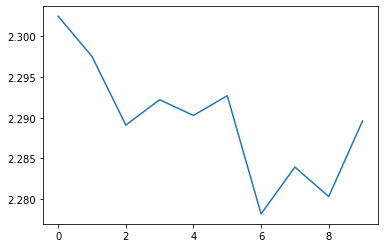

In [258]:
# let's look at the loss history!
plt.plot(loss_history)

In [163]:
# np.argmax((X.dot(W)), axis=1)
# X.dot(W).shape

In [274]:
# Let's check how it performs on validation set
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
l_hist = classifier.fit(train_X, train_y, epochs=20, learning_rate=1e-3, batch_size=300, reg=1e-6)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

22.335705740700437  >loss
2882.566265160673  >loss
inf  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss


/home/alexprog/Git_repositories/dlcourse_ai/assignments/assignment1/linear_classifer.py:262: RuntimeWarning: divide by zero encountered in log
  h = -1 * (np.log(probs))#*probs
/home/alexprog/Git_repositories/dlcourse_ai/assignments/assignment1/linear_classifer.py:284: RuntimeWarning: divide by zero encountered in reciprocal
  dW = (X_b.T.dot(dp_1)) #/ X_b.shape[0]


nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
Epoch 0, loss: nan
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
Epoch 1, loss: nan
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
Epoch 2, loss: nan
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >lo

nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
Epoch 14, loss: nan
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
Epoch 15, loss: nan
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
nan  >loss
Epoch 16, loss: nan
nan  >loss
nan  >loss
nan  

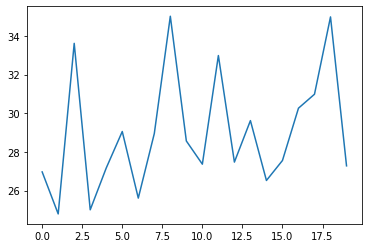

In [273]:
plt.plot(l_hist)

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [125]:
a = [2,3,6]
sorted(a)

[2, 3, 6]

In [265]:
import itertools

num_epochs = 50
batch_size = 300

learning_rates = [1e-3]#, 1e-4, 1e-5]
reg_strengths = [1e-4]#, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

best_clf = []
best_acc = []
plots = []
i = 0
for learning_rate, reg in itertools.product(learning_rates, reg_strengths):
    
    classifier = linear_classifer.LinearSoftmaxClassifier()
    
    l_hist_i = classifier.fit(
        train_X, train_y, epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size, reg=reg)
    pred_i = classifier.predict(val_X)
    accuracy_i = multiclass_accuracy(pred_i, val_y)
    best_clf.append(classifier)
    best_acc.append((accuracy_i, i))
    plots.append(l_hist_i)
    
    i += 1
    print('learning_rate={}, reg={}, Accuracy\t: {}'.format(learning_rate, reg, accuracy_i))
    
best = sorted(best_acc)[-1]
best_val_accuracy = best[0]
best_classifier = best_clf[best[1]]

b_hist = plots[best[1]]
# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

2.3036583528584917  >loss
2.3992682941959065  >loss
2.6040089688648984  >loss
2.73551316405936  >loss
2.6920798736265046  >loss
2.8075277714333953  >loss
3.072741131300625  >loss
3.4691098397467233  >loss
2.459330354846211  >loss
2.471000796126089  >loss
2.5667567250956242  >loss
2.7735134693720602  >loss
2.790497938359788  >loss
2.725383466323838  >loss
3.098290149432901  >loss
2.9542372305142313  >loss
3.119643238527546  >loss
3.0710074573492885  >loss
3.045518637416403  >loss
3.2850906378043323  >loss
3.11698805036616  >loss
3.0332574179948244  >loss
2.907258526966402  >loss
2.946529719282073  >loss
3.399621399676874  >loss
3.5471326695256318  >loss
2.882977690534142  >loss
3.0372908173248727  >loss
3.3471380598554985  >loss
3.2436656762725313  >loss
Epoch 0, loss: 3.243666
2.712547532887931  >loss
2.9804065687441503  >loss
3.31478858088973  >loss
3.1554922933728586  >loss
2.7390472761106612  >loss
2.8560003071720574  >loss
2.940184287766776  >loss
2.860948468676183  >loss
2.8285262

2.852717007081704  >loss
3.1299031784536493  >loss
2.5863188763891625  >loss
2.4583514996111697  >loss
2.340506209176247  >loss
2.335964555377379  >loss
2.4868648254509873  >loss
2.5281794699685682  >loss
2.6561369795723992  >loss
3.4163117293914818  >loss
2.709133527213679  >loss
2.6263852052918475  >loss
2.4091526115886643  >loss
2.559485952194741  >loss
Epoch 10, loss: 2.559486
2.4984368219755693  >loss
2.784491890254609  >loss
2.6840234381368875  >loss
3.132269091196941  >loss
2.5421914661481644  >loss
2.431469969557681  >loss
2.3245686385947884  >loss
2.399619381936859  >loss
2.3649151605968437  >loss
2.4610515233394694  >loss
2.425151622724993  >loss
2.583062261382506  >loss
2.4267847242425256  >loss
2.6213433667276202  >loss
2.762291871048024  >loss
2.936847874566993  >loss
2.9584313390418804  >loss
3.157288348614202  >loss
2.9627817374192524  >loss
3.107235187658062  >loss
3.291425052422352  >loss
3.2430028932050927  >loss
2.370054540651506  >loss
2.301527279269534  >loss
2.913

2.809119156972324  >loss
2.507502987325964  >loss
2.358526846025182  >loss
2.305354517319505  >loss
2.366938337214552  >loss
2.353945417560911  >loss
2.4948489479037907  >loss
3.0527887961634903  >loss
3.0355106928557682  >loss
3.3881149466894414  >loss
2.830379932330723  >loss
3.0370803149543506  >loss
3.1345533965418504  >loss
2.5357655125702627  >loss
2.4988940479596904  >loss
2.6607261086012377  >loss
2.6072961661665275  >loss
2.799529419761301  >loss
2.941067657595104  >loss
2.9272954615066884  >loss
2.885059823203609  >loss
2.706877596764034  >loss
2.4420151144781848  >loss
2.597152447234059  >loss
2.9067585181153546  >loss
2.580000896718952  >loss
Epoch 21, loss: 2.580001
2.7865213997615164  >loss
2.896238637700683  >loss
2.572116019704312  >loss
2.933167834834222  >loss
2.681334630372467  >loss
2.496696069279461  >loss
2.3109681596262157  >loss
2.241935644801159  >loss
2.1453836486332745  >loss
2.16795437883291  >loss
2.2276752333145664  >loss
2.32760014510595  >loss
2.28634896

Epoch 31, loss: 2.578757
2.750277867736754  >loss
3.1445240397979712  >loss
2.549516183634966  >loss
2.4891224076330496  >loss
2.3049763594097468  >loss
2.4681039223412617  >loss
2.935938884542494  >loss
3.074950020541246  >loss
3.0988795856406997  >loss
2.616068491747541  >loss
2.4696705178563683  >loss
2.4713535060343945  >loss
2.459125963184294  >loss
2.864532283435333  >loss
3.0560665399569307  >loss
2.806333717266725  >loss
2.7397913282909996  >loss
2.7328437289566962  >loss
2.612405646264362  >loss
2.762958330089388  >loss
2.7121808520261994  >loss
3.0815666216088626  >loss
2.974277341237088  >loss
2.669257729021496  >loss
2.4463978648953644  >loss
2.810704676909106  >loss
2.778414451370478  >loss
2.7152905481023106  >loss
2.7050757978218027  >loss
3.053266941152026  >loss
Epoch 32, loss: 3.053267
3.2410889290855027  >loss
2.8161477097246417  >loss
2.8894177656598785  >loss
3.0003264796348166  >loss
3.0553753837582507  >loss
3.2503929746555427  >loss
3.365944137832325  >loss
2.87

2.390990881815143  >loss
2.2093549499041147  >loss
2.4270444192169367  >loss
2.6611058836372523  >loss
2.6110882664924957  >loss
2.5345665119576775  >loss
3.081496691549013  >loss
2.689211588619681  >loss
2.3184692629686228  >loss
2.5150758564997666  >loss
2.809762313080816  >loss
Epoch 42, loss: 2.809762
2.6168353133560145  >loss
2.8337144647986587  >loss
2.6700720938593987  >loss
2.316701148949023  >loss
2.460466716400154  >loss
2.541466280407192  >loss
2.480655245783053  >loss
2.436841526311781  >loss
2.665870635585998  >loss
2.8790381847798363  >loss
2.9796286461936923  >loss
3.076515814450047  >loss
3.194864743451706  >loss
2.777508173847524  >loss
2.535937615248938  >loss
2.619822488704425  >loss
2.5378163767513366  >loss
2.864643951658924  >loss
2.8549463660684884  >loss
2.7659529388063167  >loss
2.7870152073664305  >loss
2.522221989799815  >loss
2.487369230880599  >loss
2.742675054859717  >loss
3.0225507559592315  >loss
3.104551181835756  >loss
2.762438117138373  >loss
2.540733

In [262]:
print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.207000


# Какой же точности мы добились на тестовых данных?

In [263]:
test_pred = best_classifier.predict(test_X)
# test_pred = classifier.predict(test_X)

test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.179000


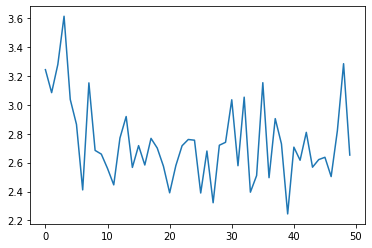

In [266]:
plt.plot(b_hist)

In [95]:
learning_rate=1e-7
reg=1e-5
epochs=2
batch_size=300
X = train_X
y = train_y

num_train = X.shape[0]
# num_train
num_features = X.shape[1]
# num_features
num_classes = np.max(y)+1
# num_classes
# if self.W is None:
W = 0.001 * np.random.randn(num_features, num_classes)
loss_history = []
for epoch in range(epochs):
    shuffled_indices = np.arange(num_train)
    # shuffled_indices
    np.random.shuffle(shuffled_indices)
    sections = np.arange(batch_size, num_train, batch_size)
    # sections
    # num_train, num_features
    batches_indices = np.array_split(shuffled_indices, sections)
    print(np.array(batches_indices).shape)
    # target_index = np.ones(batch_size, dtype=np.int)
    np.random.seed(42)

    target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
    losses = []

    for batch in batches_indices:
        X_b = X[batch]
#         W_b = W[batch]
#         print(X_b.shape)
        predictions = np.dot(X_b, W)
        predictions1 = predictions.copy()
    #     print(predictions)
#         try:
#         predictions1 -= np.max(predictions1)    
        predictions1 -= np.array(np.max(predictions, axis=1)).reshape(predictions.shape[0], 1)
#         print(predictions1)
#         exponents = np.exp(predictions1)
#         probs = exponents / np.sum(exponents)

        probs = np.exp(predictions1) / np.sum(np.exp(predictions1), axis=1, keepdims=True)
        h = -1 * (np.log(probs))
#         print('h :\n', h)
#         loss = (h[:, target_index])
        loss = (h[np.arange(target_index.shape[0]), target_index.T])
#         print('loss array :', loss)

        loss = np.sum(loss) / loss.shape[0]
#         print('loss :', loss)

        zeros = np.zeros_like(predictions)
#         zerosW = np.zeros_like(W)

#         zeros = np.zeros_like(W)

        zeros[np.arange(target_index.shape[0]), target_index.T] = 1
#         zerosW[np.arange(target_index.shape[0]), target_index.T] = 1
#         zeros[:, target_index] = 1

        dp =  (probs - zeros)
#         print('dp :', dp)
#         dw =  (W - zerosW)
#         dW = W.dot(dp)
        dW = (X_b.T.dot(dp)) / X_b.shape[0]
#         (self.p - self.y) / self.y.shape[0]

        loss += reg * np.sum(W**2)

        W = W - learning_rate * dW
        print(loss)
        losses.append(loss)

    print(losses)
    loss1 = sum(losses)/len(losses)
#         loss_history.append(loss1)

        # TODO implement prediction and gradient over W
    # Your final implementation shouldn't have any loops
#         except:
#             raise Exception("Not implemented NOW!!!")

#     return loss, dW

    
    
#     loss_history.append(loss)
    print("Epoch %i, loss: %f" % (epoch, loss1))

(30, 300)
690.7709241839443
691.0638871762108
690.9386846194352
690.6635597300074
690.8223377198838
690.8508275072097
690.8821068413731
690.5881559466872
690.8620735712747
690.8910550196562
690.7159675644227
690.5451357405011


<ipython-input-95-b36214258f04>:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)


690.9428677601114
690.9379335229087
690.636831982748
690.6974160869652
690.6469604641562
690.7374034296702
690.6372204715057
690.7984643082164
690.7315775468021
690.6720068554637
690.6355063421239
690.653609423868
690.8866936882906
690.6932082002365
691.1023636508205
690.9698700549659
690.7397618463228
690.8123658762202
[690.7709241839443, 691.0638871762108, 690.9386846194352, 690.6635597300074, 690.8223377198838, 690.8508275072097, 690.8821068413731, 690.5881559466872, 690.8620735712747, 690.8910550196562, 690.7159675644227, 690.5451357405011, 690.9428677601114, 690.9379335229087, 690.636831982748, 690.6974160869652, 690.6469604641562, 690.7374034296702, 690.6372204715057, 690.7984643082164, 690.7315775468021, 690.6720068554637, 690.6355063421239, 690.653609423868, 690.8866936882906, 690.6932082002365, 691.1023636508205, 690.9698700549659, 690.7397618463228, 690.8123658762202]
Epoch 0, loss: 690.784226
(30, 300)
690.8064878637574
690.6986753841239
690.7156184127408
690.7534265094378
6

In [158]:
y[:15]

array([9, 9, 2, 1, 7, 1, 3, 5, 3, 6, 4, 2, 9, 1, 0], dtype=uint8)

In [159]:
pred[:15]

array([2, 4, 4, 3, 5, 7, 5, 1, 2, 5, 5, 1, 1, 2, 1])

In [ ]:
def check_gradient1(f, x, delta=1e-5, tol = 1e-4):
    
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"

    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    # We will go through every dimension of x and compute numeric
    # derivative for it
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
#         print('it>>>>>>', np.array([i for i in it]))

        analytic_grad_at_ix = analytic_grad[ix]
        print('ix :', ix)
        print('x :', x) 
        print('f(x) :', f(x))
        numeric_grad_at_ix = 0

        # TODO compute value of numeric gradient of f to idx       
        orig_x[ix] += delta
        f1 = f(orig_x)
        orig_x[ix] -= 2 * delta
        f2 = f(orig_x)
        
        numeric_grad_at_ix = (f1[0] - f2[0]) / (2 * delta)
        
        print('numeric_grad_at_ix :', numeric_grad_at_ix)
        
        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


In [ ]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import random 

def generateSample(N, variance=100): 
    
    X = np.matrix(range(N)).T + 1 
    Y = np.matrix([random.random() * variance + i * 10 + 900 for i in range(len(X))]).T 
    
    return X, Y 


def fitModel_gradient(x, y): 
    
    N = len(x) 
    w = np.zeros((x.shape[1], 1)) 
    eta = 0.0001 
    maxIteration = 100000 
    
    for i in range(maxIteration): 
        error = x * w - y 
        gradient = xT * error / N 
        w = w - eta * gradient 
        
    return w 
    
    def plotModel(x, y, w): 
        
        plt.plot(x[:,1], y, "x") 
        plt.plot(x[:,1], x * w, "r-") 
        plt.show() 
        
        
    def test(N, variance, modelFunction): 
        
        X, Y = generateSample(N, variance) 
        X = np.hstack([np.matrix(np.ones(len(X))).T, X]) 
        w = modelFunction(X, Y) 
        plotModel(X, Y, w) 
        test(50, 600, fitModel_gradient) 
        test(50, 1000, fitModel_gradient) 
        test(100, 200, fitModel_gradient) 